# UrbanSound8K - Analysis 
In this notebook, we look at the time durations and sample rates of the audio files in the UrbanSound8K dataset. These 2 parameters are not uniform across the dataset, thus we will need to choose a strategy to standardize them before we can use them for training a model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa 

from sklearn.utils import class_weight

7997.047244094487


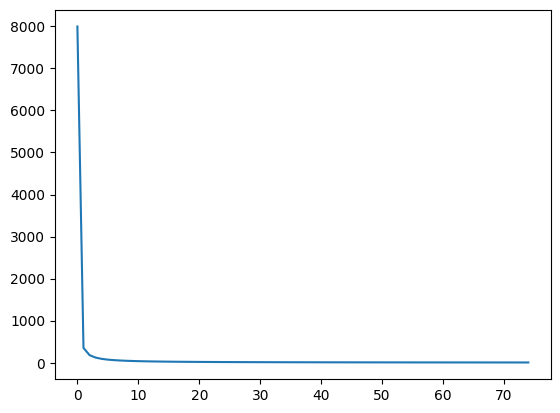

In [2]:
import pywt 

dt = 0.00016
#scales = np.geomspace(0.635, 128, num=75)
scales = np.linspace(0.635, 1024, num=75)
freq = pywt.scale2frequency('morl', scales) / dt

print(freq[0])

plt.plot(freq)
plt.show()

In [3]:
# Load dataset metadata
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

Here we add a new column to the metadata file that contains the duration of the audio files in seconds and plot the distribution of the time durations. 

In [4]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(metadata['classID']), y=metadata['classID'])

In [5]:
dict(enumerate(class_weights))

{0: 0.8732,
 1: 2.0354312354312354,
 2: 0.8732,
 3: 0.8732,
 4: 0.8732,
 5: 0.8732,
 6: 2.3347593582887702,
 7: 0.8732,
 8: 0.939935414424112,
 9: 0.8732}

In [6]:
# For each class print number of samples 
for i in range(10):
    print('Class {}: {}'.format(i, np.sum(metadata['classID'] == i)))

Class 0: 1000
Class 1: 429
Class 2: 1000
Class 3: 1000
Class 4: 1000
Class 5: 1000
Class 6: 374
Class 7: 1000
Class 8: 929
Class 9: 1000


In [7]:
for category, weight in zip(np.unique(metadata['class']), class_weights):
    print(f'Class {category} has weight {weight}')

Class air_conditioner has weight 0.8732
Class car_horn has weight 2.0354312354312354
Class children_playing has weight 0.8732
Class dog_bark has weight 0.8732
Class drilling has weight 0.8732
Class engine_idling has weight 0.8732
Class gun_shot has weight 2.3347593582887702
Class jackhammer has weight 0.8732
Class siren has weight 0.939935414424112
Class street_music has weight 0.8732


Time duration summary
 count    8732.000000
mean        3.607904
std         0.973570
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000


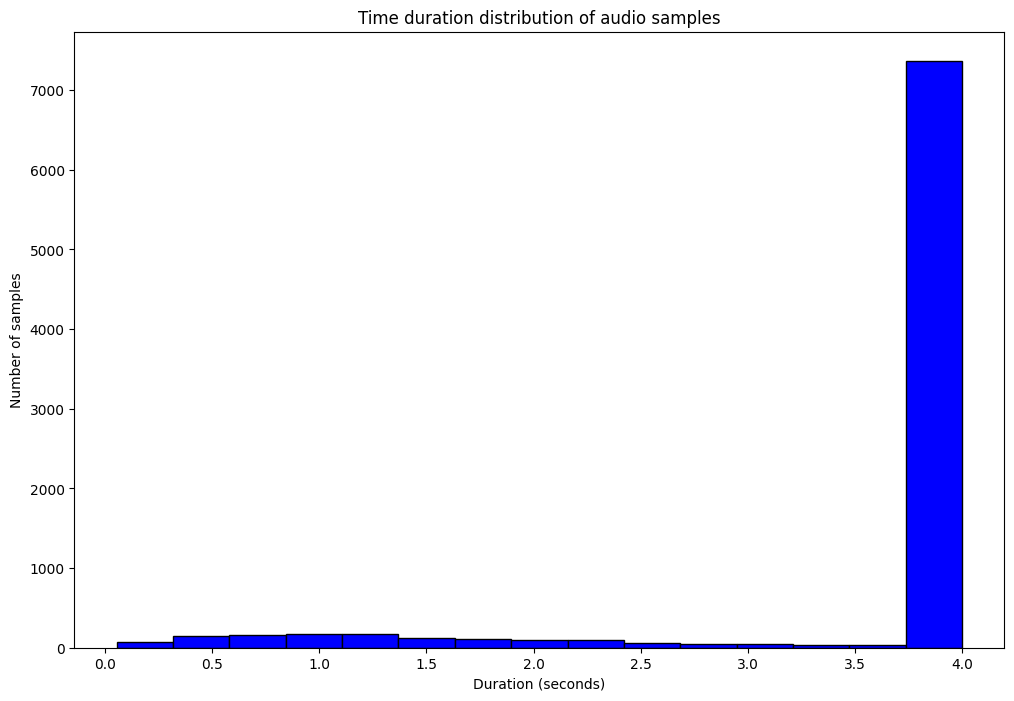

In [8]:
metadata['duration_csv'] = metadata['end'] - metadata['start']
print('Time duration summary\n', metadata['duration_csv'].describe().to_string())

# Plotting the distribution of the duration of the audio files
plt.figure(figsize=(12, 8))
plt.hist(metadata['duration_csv'], bins=15, color='blue', edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of samples')
plt.title('Time duration distribution of audio samples')
plt.show()

We see that the vast majority of the audio samples are 4 seconds long. The best strategy would be to pad the audio files that are shorter than 4 seconds with zeros (silence), as this would not introduce any new information into the sampels, and moreover, convolutional neural networks are translation and scale invariant, so the padding should not affect the performance of the model.

Let's analyze more in depth the duration of the audio files, because the metadata could be slightly wrong in some cases, and this could cause problems when padding the audio files.

In [9]:
# Shuffle the dataset
metadata = metadata.sample(frac=1).reset_index(drop=True)
file_paths = ['UrbanSound8K/audio/fold' + str(row['fold']) + '/' + row['slice_file_name'] for index, row in metadata.iterrows()]

time_durations = [librosa.get_duration(path=file_path) for file_path in file_paths]
metadata['duration_librosa'] = time_durations

In [10]:
metadata[['duration_csv', 'duration_librosa']].describe()

,duration_csv,duration_librosa
count,8732.000000,8732.000000
mean,3.607904,3.607522
std,0.973570,0.974394
min,0.054517,0.050000
25%,4.000000,4.000000
50%,4.000000,4.000000
75%,4.000000,4.000000
max,4.000000,4.036647


Indeed, we see that the maximum duration obtained with librosa is 4.036647 seconds, which is slightly longer than 4 seconds. Assuming that the maximum duration is 4 seconds could have caused issues when padding the audio files.

In the next block, we add a new column to the metadata file that contains the sample rate of the audio files and plot the distribution of the sample rates.

Sampling rates summary
count      8732.000000
mean      48456.979272
std       15300.080707
min        8000.000000
25%       44100.000000
50%       44100.000000
75%       48000.000000
max      192000.000000

sampling_rate
44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4


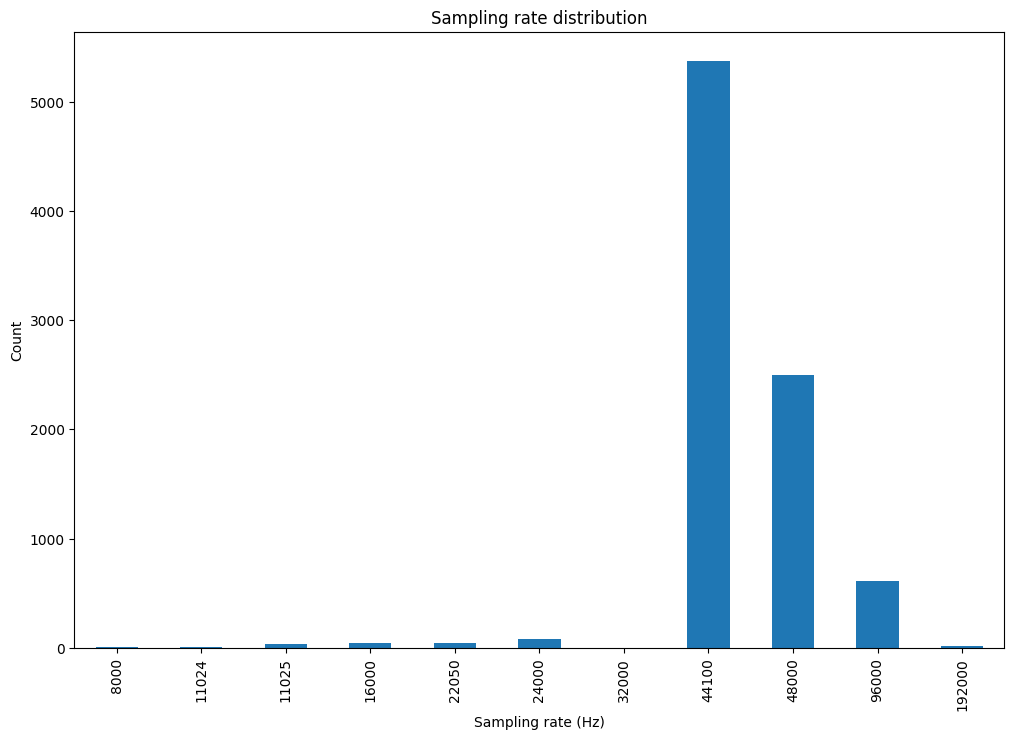

In [11]:
sampling_rates = [librosa.get_samplerate(file_path) for file_path in file_paths]

metadata['sampling_rate'] = sampling_rates

print('Sampling rates summary\n' + metadata['sampling_rate'].describe().to_string() + '\n')
print(metadata['sampling_rate'].value_counts().to_string())

# Plotting the distribution of the sampling rates
sampling_rates = metadata['sampling_rate'].value_counts().sort_index()
plt.figure(figsize=(12, 8))
sampling_rates.plot(kind='bar')
plt.title('Sampling rate distribution')
plt.xlabel('Sampling rate (Hz)')
plt.ylabel('Count')
plt.show()

We see that we have 2 dominant sample rates, 44100 Hz (standard CD quality) and 48000 Hz. We will need to resample the audio files to a common sample rate before we can use them for training a model. We will choose 44100 Hz as the common sample rate, as it is the most common sample rate in the dataset. After resampling, we will pad the audio files to 4 seconds as discussed above.

In [12]:
from IPython.display import Audio

subclasses = ['children_playing', 'siren']

# Load only files from class1 and class2
file_paths_restricted = ['UrbanSound8K/audio/fold' + str(row['fold']) + '/' + row['slice_file_name'] for _, row in metadata.iterrows() if row['class'] in subclasses]

audio_samples = [librosa.load(file_path, sr=16000)[0] for file_path in file_paths_restricted]
class_labels = [row['class'] for _ , row in metadata.iterrows() if row['class'] in subclasses]

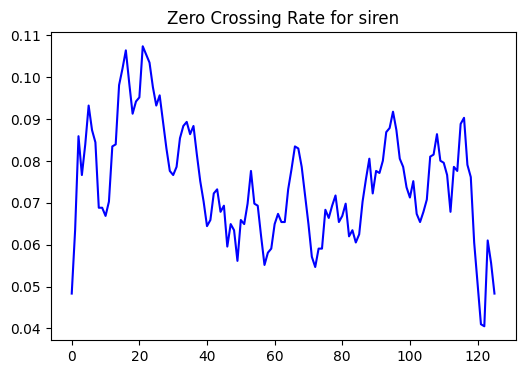

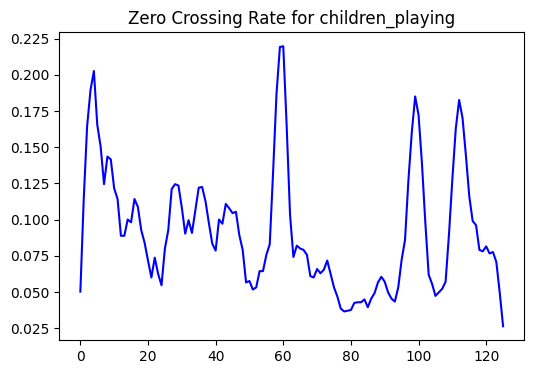

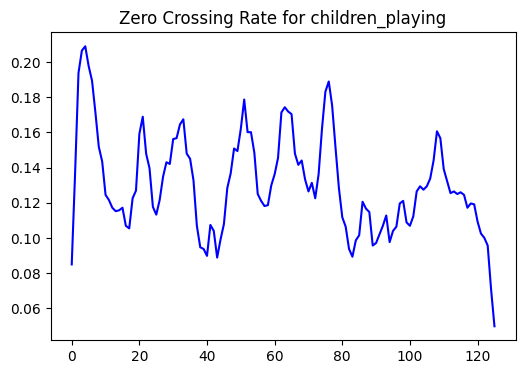

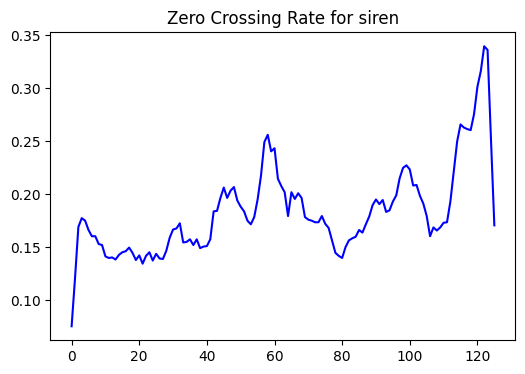

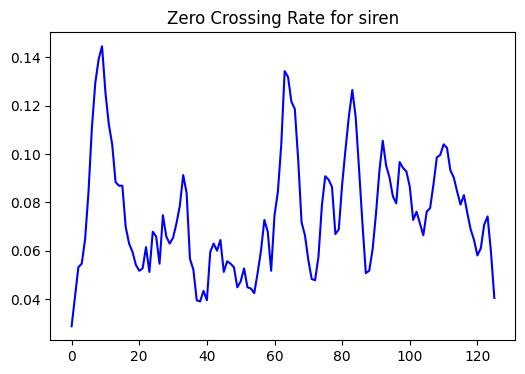

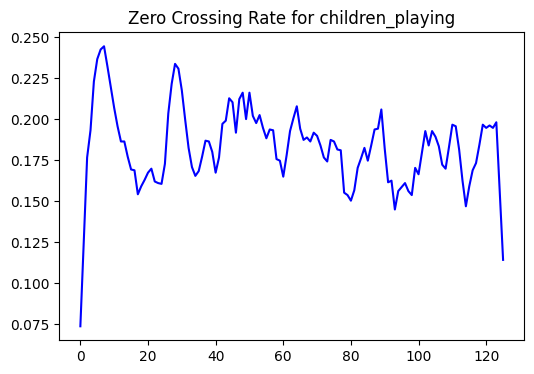

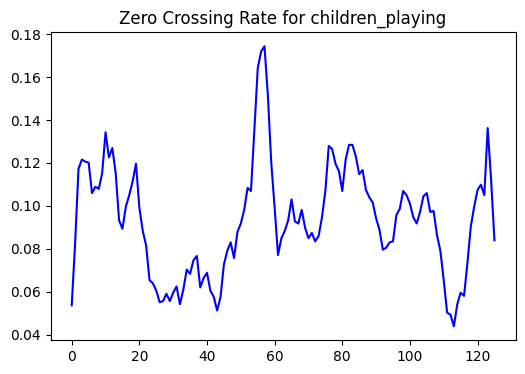

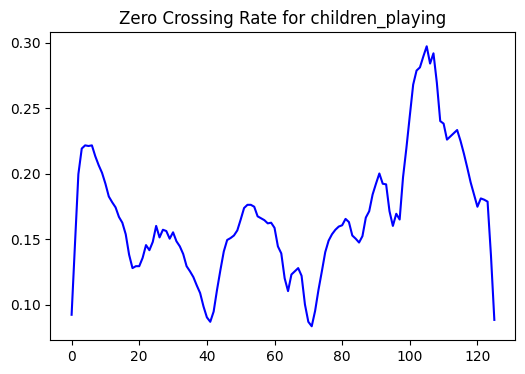

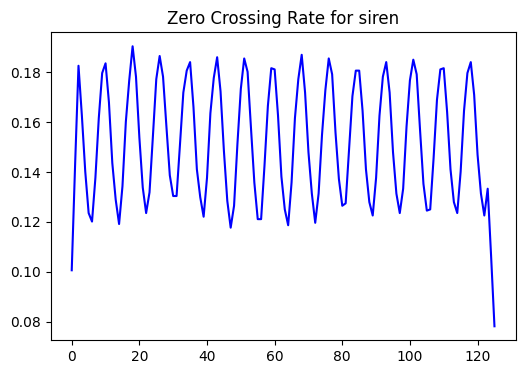

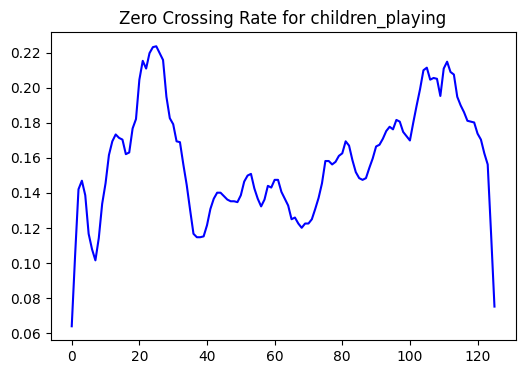

In [13]:
zero_crossing_rates = [librosa.feature.zero_crossing_rate(audio_sample)[0] for audio_sample in audio_samples]

for zcr, class_label in zip(zero_crossing_rates[:10], class_labels[:10]):
    plt.figure(figsize=(6, 4))
    plt.plot(zcr, color='blue')
    plt.title(f'Zero Crossing Rate for {class_label}')
    plt.show()

Shape of the mel spectrogram: (128, 126)


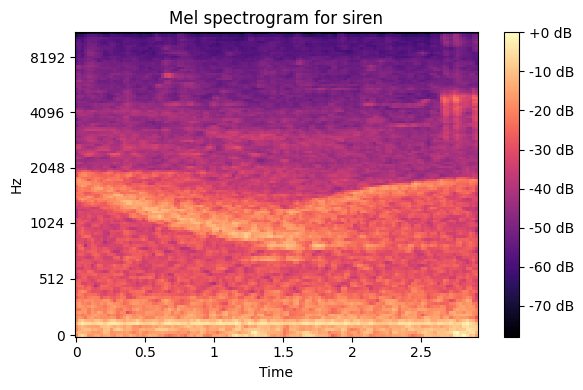

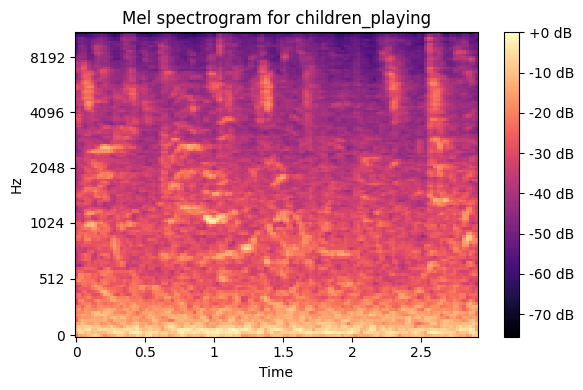

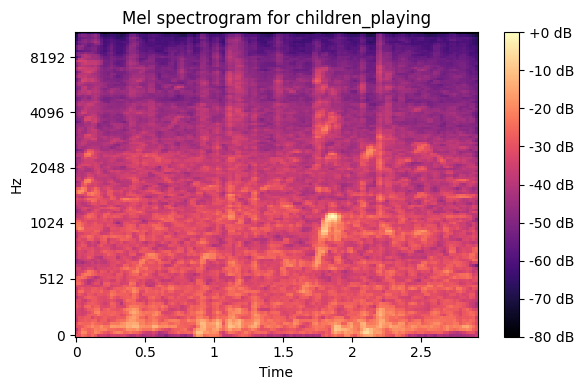

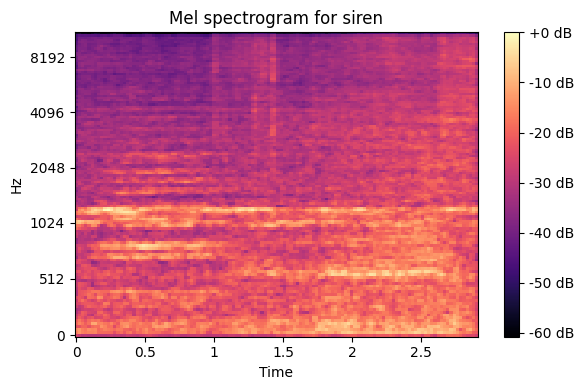

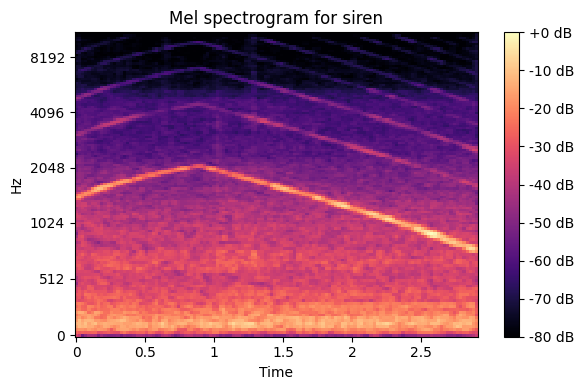

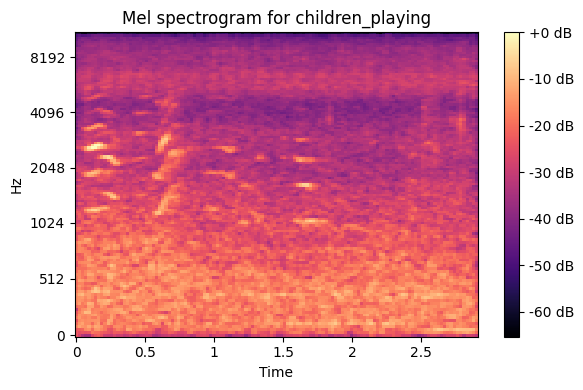

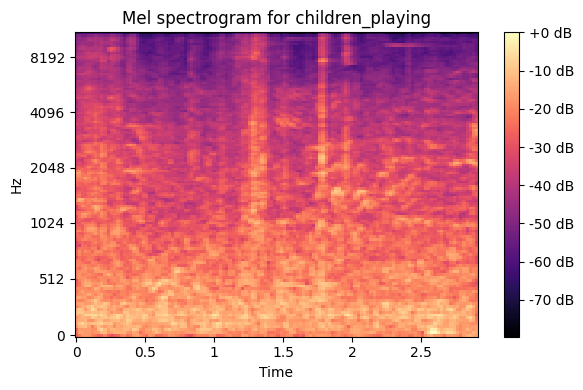

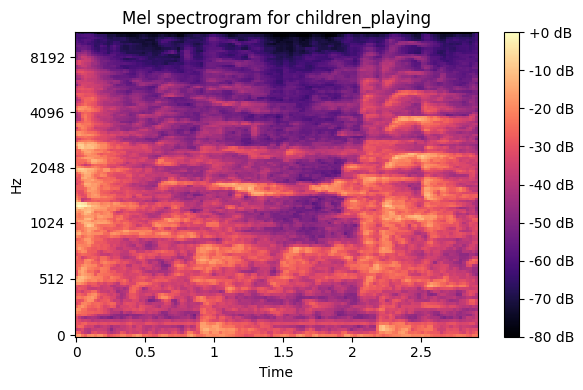

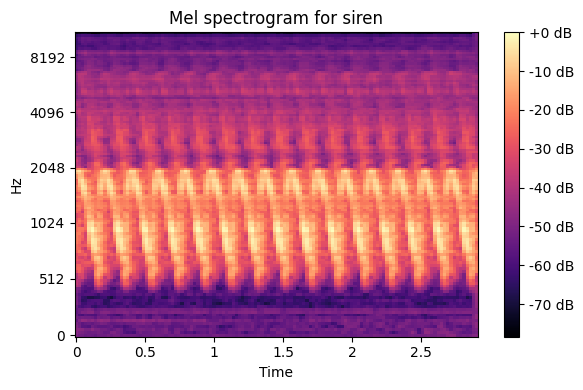

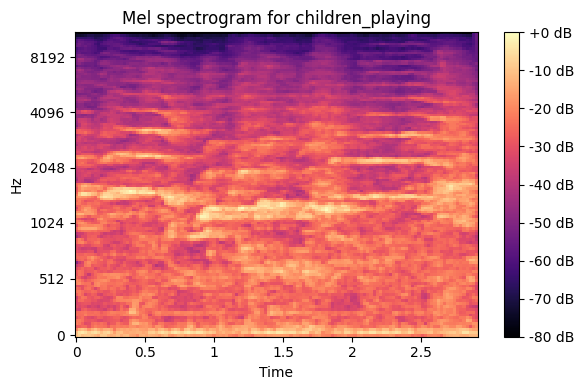

In [14]:
mel_specgrams = [librosa.feature.melspectrogram(y=audio_sample, sr=16000) for audio_sample in audio_samples[:10]]
print('Shape of the mel spectrogram:', mel_specgrams[0].shape)

for mel_specgram, class_label in zip(mel_specgrams, class_labels[:10]):
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(librosa.power_to_db(mel_specgram, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram for {class_label}')
    plt.tight_layout()
    plt.show()

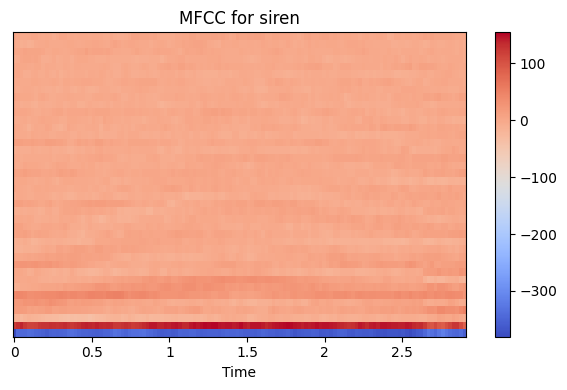

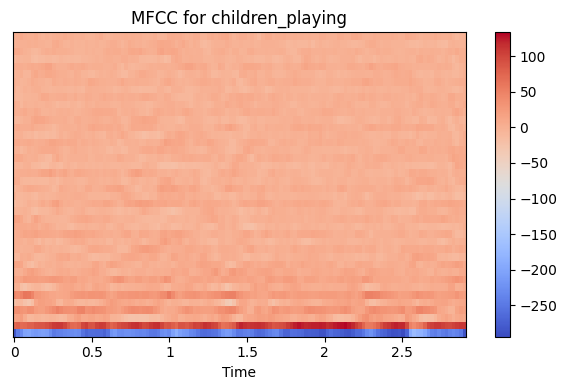

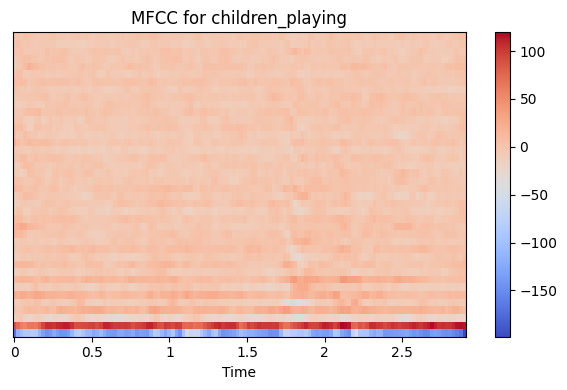

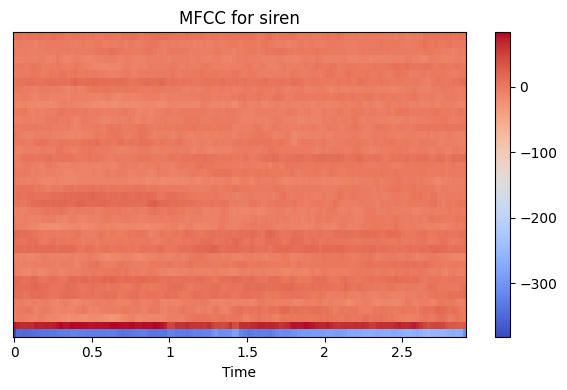

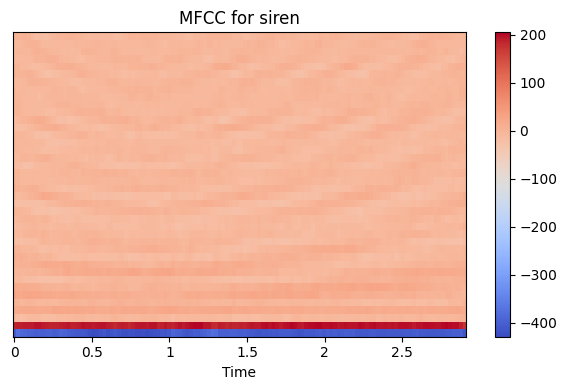

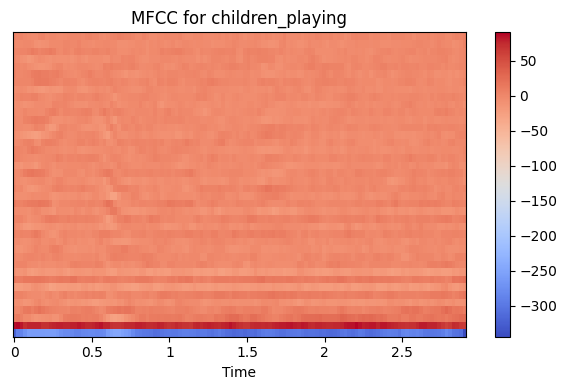

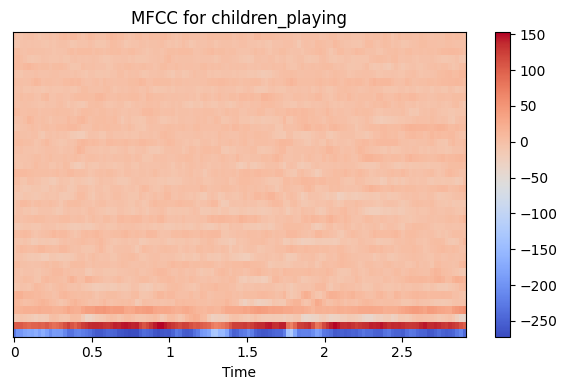

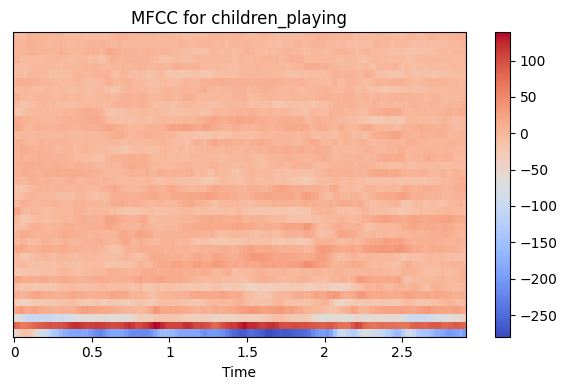

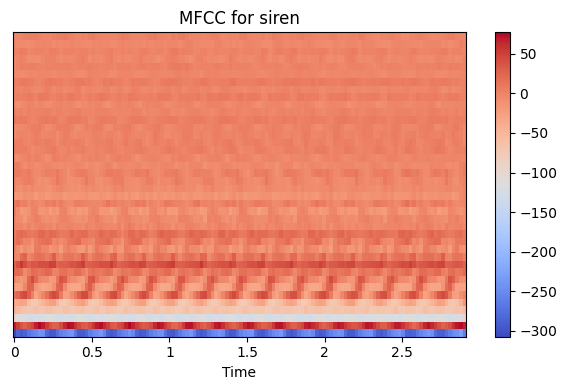

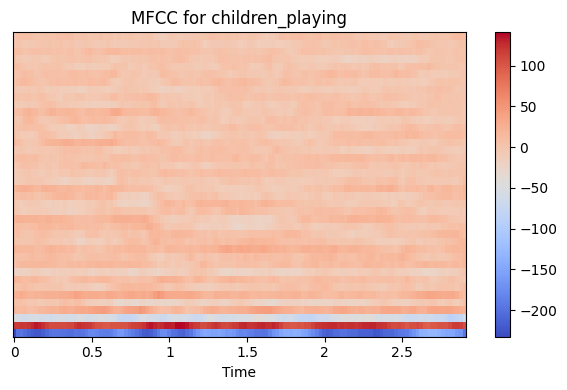

In [15]:
mfccs = [librosa.feature.mfcc(y=audio_sample, sr=16000, n_mfcc=40) for audio_sample in audio_samples[:10]]

for mfcc, class_label in zip(mfccs, class_labels[:10]):
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC for {class_label}')
    plt.tight_layout()
    plt.show()

/var/folders/pt/96wmlhhx5c73vx_5dsxgkytw0000gn/T/ipykernel_99327/3728458508.py:5: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(feature, ref=np.max), y_axis='log', x_axis='time')


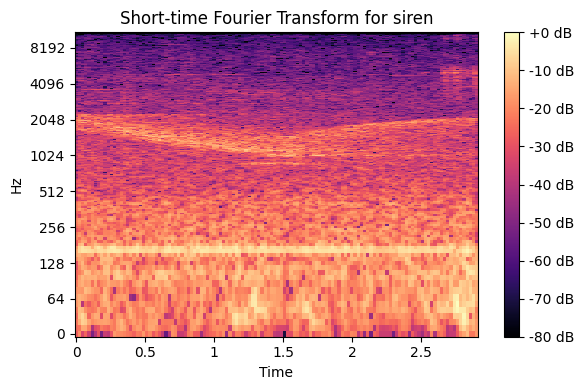

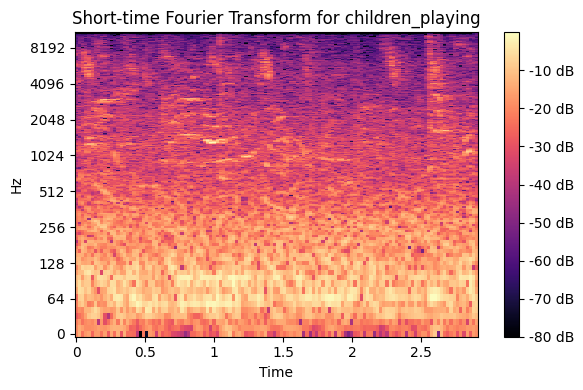

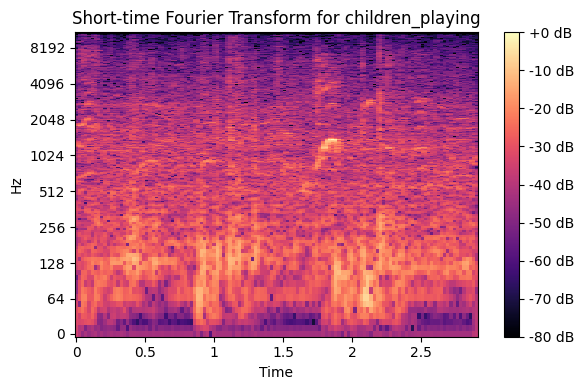

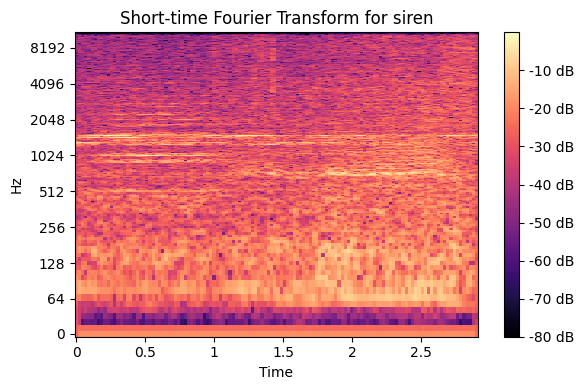

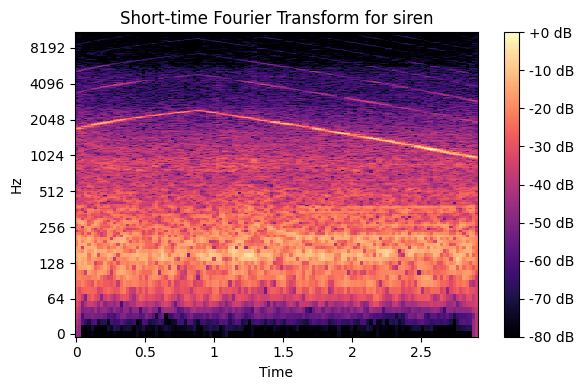

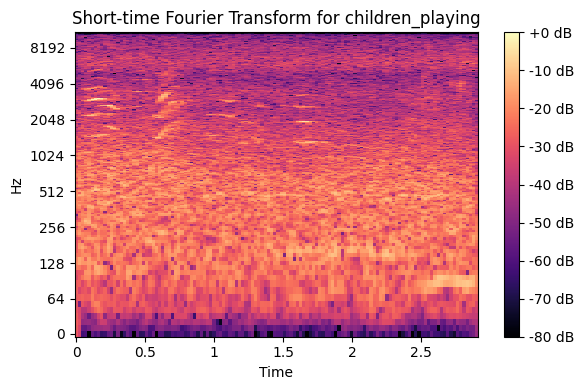

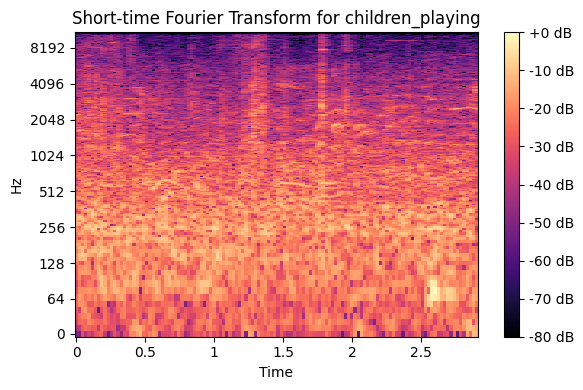

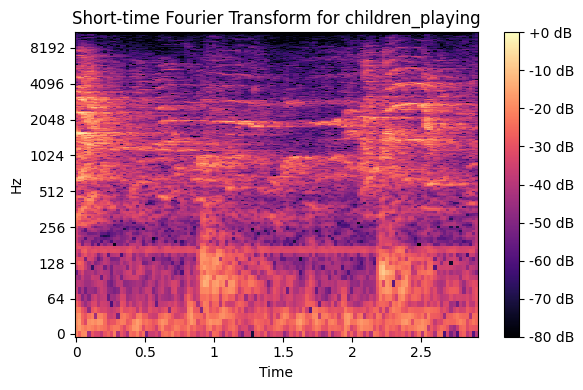

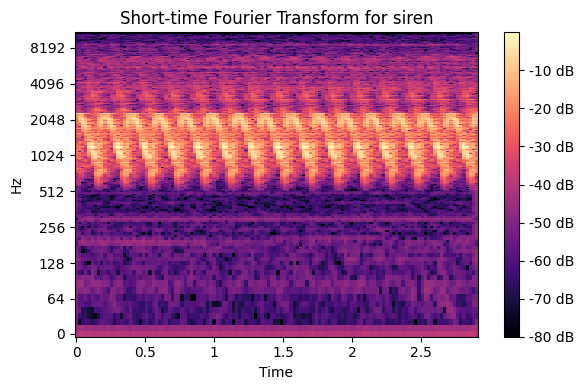

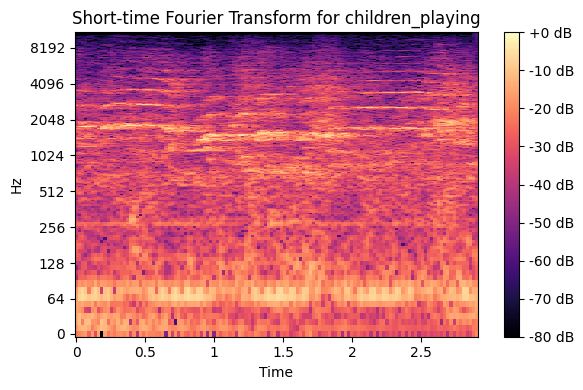

In [16]:
features = [librosa.stft(y=audio_sample) for audio_sample in audio_samples[:10]]

for feature, class_label in zip(features, class_labels[:10]):
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(librosa.amplitude_to_db(feature, ref=np.max), y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Short-time Fourier Transform for {class_label}')
    plt.tight_layout()
    plt.show()